In [17]:
import os
import json
import torch
import numpy as np
from sys import exit
from skimage.io import imread
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor 

from common import kitti_crop_image_list, kitti_adjust_intrinsic

class CarlaDataset(Dataset):
    def __init__(self,
                 args,
                 images_root,
                 flip_augmentations=True,
                 preprocessing_crop=True,
                 crop_size=[370, 1224],
                 num_examples=-1,
                 index_file=None):

        self._args = args
        self._seq_len = 1
        self._flip_augmentations = flip_augmentations
        self._preprocessing_crop = preprocessing_crop
        self._crop_size = crop_size
        
        self._image_list = []
        self._pose_list = []
        self._intrinsics = torch.from_numpy(np.loadtxt(os.path.join(images_root, 'intrinsics.txt'))).float()
        
        view1 = os.path.join(images_root, 'left')
        view2 = os.path.join(images_root, 'right')
        poses = os.path.join(images_root, 'poses')
        
        ext_dict = {
            'rgb': '.png',
            'depth': '.tif',
            'segmentation': '.png',
            'poses': '.json'
        }
        
        self._output_keys = [
            'rgb_l1',
            'rgb_l2',
            'rgb_r1',
            'rgb_r2',
            'depth_l1',
            'depth_l2',
            'depth_r1',
            'depth_r2',
            'seg_l1',
            'seg_l2',
            'seg_r1',
            'seg_r2',
            'ego_trans',
            'k_l',
            'k_r'
        ]
        
        num_imgs = len(os.listdir(os.path.join(view1, 'rgb')))
        
        for idx in range(num_imgs-1):
            idx_tgt = str(idx+1)
            idx = str(idx)
            paths = []
            file_num = '0' * (6 - len(idx)) + idx
            file_num_tgt = '0' * (6 - len(idx_tgt)) + idx_tgt
            for sensor, ext in ext_dict.items():
                if sensor == 'poses':
                    paths.append(os.path.join(images_root, sensor, f"{sensor}_{file_num+ext}"))
                    paths.append(os.path.join(images_root, sensor, f"{sensor}_{file_num_tgt+ext}"))
                else:
                    for view in [view1, view2]:
                        paths.append(os.path.join(view, sensor, f"{sensor}_{file_num+ext}"))
                        paths.append(os.path.join(view, sensor, f"{sensor}_{file_num_tgt+ext}"))
            self._image_list.append(paths)
        
        self._size = len(self._image_list)
        
    def __getitem__(self, index):
        index %= self._size
        
        # [rgbL12, rgbR12, depthL12, depthR12, segL12, segR12, poseLR1, poseLR2] # 14 files
        data = [imread(path) for path in self._image_list[index][:-2]]
        h_orig, w_orig, _ = data[0].shape
        input_im_size = torch.from_numpy(np.array([h_orig, w_orig])).float()
        
        # cropping 
        if self._preprocessing_crop:
            # get starting positions
            crop_height = self._crop_size[0]
            crop_width = self._crop_size[1]
            x = np.random.uniform(0, w_orig - crop_width + 1)
            y = np.random.uniform(0, h_orig - crop_height + 1)
            crop_info = [int(x), int(y), int(x + crop_width), int(y + crop_height)]

            # cropping images and adjust intrinsic accordingly
            img_list_np = kitti_crop_image_list(data, crop_info)
            k_l1, k_r1 = kitti_adjust_intrinsic(self._intrinsics, self._intrinsics, crop_info)
        data = [to_tensor(x) for x in data]
        pose_1 = self.read_pose(self._image_list[index][-2])
        pose_2 = self.read_pose(self._image_list[index][-1])
        ego_trans = torch.from_numpy(np.dot(pose_2, np.linalg.inv(pose_1)))
        data.extend([ego_trans, k_l1, k_r1])
        output_dict = {key: val for key, val in zip(self._output_keys, data)}
        return output_dict

    def read_pose(self, path):
        with open(path) as f:
            d = json.load(f)
            T = np.array(d['vehicle']['transform'])
        return T

In [19]:
dataset = CarlaDataset(args=None, images_root='/external/datasets/carla_stereo/Town01/')

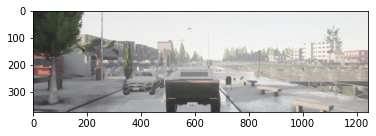

In [27]:
plt.imshow(dataset[0]['rgb_r1'].permute(1, 2, 0))